In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import timeit
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10,15)
ds = sio.loadmat('face.mat')

In [2]:
X = ds['X']
l = ds['l'][0]
split = 0.8
W = 46
H = 56
IDs = 52
X = pd.DataFrame(X.transpose())
N = X.shape[0]*split
l = pd.DataFrame(l)

In [3]:
X_train, X_test, l_train, l_test = train_test_split(X, l, test_size=(1-split), stratify = l, random_state=18)
# X_bar = np.mean(X, axis=1)
X_train, X_test = X_train.values, X_test.values
l_train, l_test = l_train.values, np.transpose(l_test.values)
X_bar = np.transpose([np.mean(X_train, axis=0)])
X_bar = np.ndarray.flatten(X_bar)
print(l_train.shape)

(416, 1)


In [4]:
train_subspaces = []
for i in range(IDs):
    images = []
    for j in range(int(N)):
        if l_train[j][0] == i+1:
            images.append(X_train[j])
    train_subspaces.append(images)
print('    shape:', np.asarray(train_subspaces).shape)

    shape: (52, 8, 2576)


In [5]:
eigen_subspaces = []
elements = np.asarray(train_subspaces[0])
elements_mean = np.mean(elements, axis=0)
elements = np.subtract(elements,elements_mean)
S_W = np.matmul(elements.T,elements)
mean_diff = np.atleast_2d(elements_mean)-X_bar
S_B = np.matmul(mean_diff.T, mean_diff)
S = np.matmul(elements,np.transpose(elements))
w, v = np.linalg.eig(S)
U = preprocessing.normalize(np.matmul(np.transpose(elements),v), axis=0)
eigen_subspaces.append([U,elements_mean])
for i in range(1,IDs):
    elements = np.asarray(train_subspaces[i])
    elements_mean = np.mean(elements, axis=0)
    elements = np.subtract(elements,elements_mean)
    S_W += np.matmul(elements.T,elements)
    mean_diff = np.atleast_2d(elements_mean)-X_bar
    S_B += np.matmul(mean_diff.T, mean_diff)
    S = np.matmul(elements,np.transpose(elements))
    w, v = np.linalg.eig(S)
    U = preprocessing.normalize(np.matmul(np.transpose(elements),v), axis=0)
    eigen_subspaces.append([U,elements_mean])

In [6]:
print('    ', S_W.shape)
print('    ', S_B.shape)

print('    ', np.linalg.matrix_rank(S_W))
print('    ', np.linalg.matrix_rank(S_B))
print('    ', N-52)

     (2576, 2576)
     (2576, 2576)
     364
     51
     364.0


(416, 416)


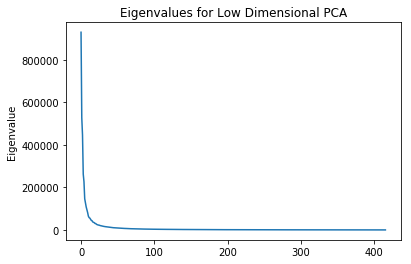

(2576, 200)


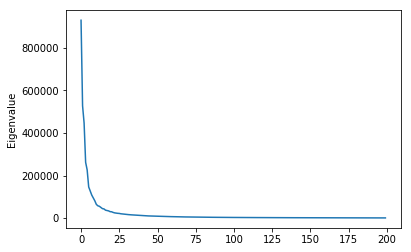

In [7]:
A = np.subtract(X_train,X_bar).T
print(np.matmul(A.T,A).shape)
w_pca, v_pca = np.linalg.eig((1/N)*np.matmul(A.T,A))
inds = w_pca.argsort()[::-1]
w_pca = w_pca[inds]
v_pca = v_pca[:,inds]
plt.plot(w_pca)
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues for Low Dimensional PCA')
plt.show()
cum_w = np.cumsum(w_pca)/np.sum(w_pca);
# M_pca = np.argmax(cum_w>0.95)
M_pca = 200
w_pca = w_pca[:M_pca]
v_pca = v_pca[:,:M_pca]
v_pca = preprocessing.normalize(np.matmul(A,v_pca), axis=0)
print(v_pca.shape)
plt.plot(np.abs(w_pca))
plt.ylabel('Eigenvalue')
plt.show()

c:\users\jack\appdata\local\programs\python\python37-32\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


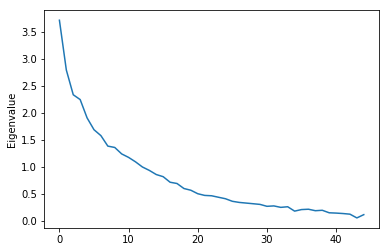

In [8]:
meh2 = np.dot(np.dot(v_pca.T,S_W),v_pca)
meh1 = np.dot(np.dot(v_pca.T,S_B),v_pca)

M_lda = 45
w_fld, v_fld = np.linalg.eig(np.linalg.inv(meh2).dot(meh1))
w_fld = w_fld[:M_lda]
v_fld = v_fld[:,:M_lda]

plt.plot(w_fld)
plt.ylabel('Eigenvalue')
plt.show()

In [9]:
# v_opt = np.zeros((2576,51))
# print(v_pca.shape)
# for i in range(2576):
#     for j in range(M_pca):
# #         print(i)
# #         print(j)
#         v_opt[i,j] = v_pca[i,j]*v_lda[i,j]
v_opt = np.dot(v_pca,v_fld)
v_opt = preprocessing.normalize(np.real(v_opt),axis=0)
print(np.transpose(v_opt)[0].shape)
# train_img = np.transpose(np.array_split(np.transpose(v_opt)[0], W))
# imgplot = plt.imshow(train_img, cmap='gray')


(2576,)


In [10]:
Y_train = []
print(A.shape)
for i in range(int(N)):
    Y_train.append(np.matmul(v_opt.T,X_train[i]))
    

(2576, 416)


In [11]:
correct = 0
# X_test_norm = np.subtract(X_test,X_bar)
l_pred = []
X_test_norm = X_test
for i in range(len(X_test)):
    y_test = np.matmul(v_opt.T,X_test_norm[i])
    diff = np.subtract(Y_train, y_test)
    value = np.argmin(np.diag(np.matmul(diff, diff.T)))
    l_pred.append(l_train[value])
    if l_train[value] == l_test[0][i]:
        correct += 1
print('    ', correct/len(l_test[0]))

     0.9134615384615384


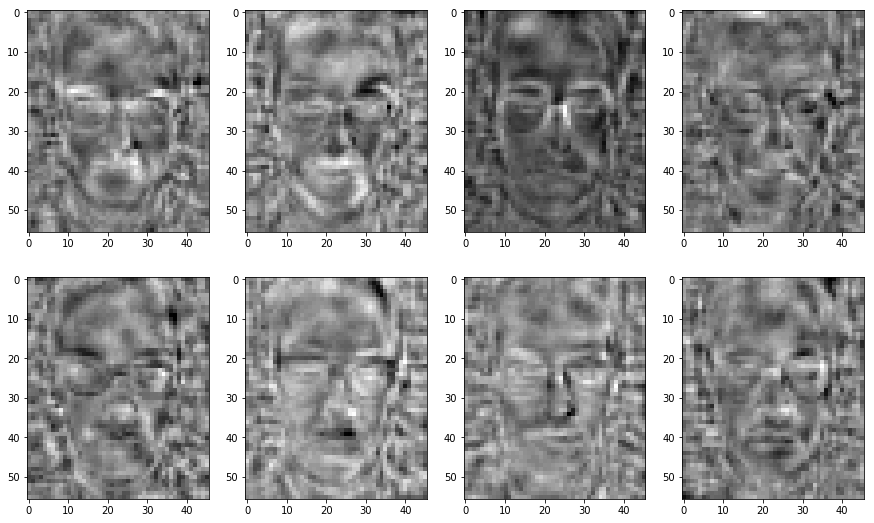

In [12]:
plt.figure(figsize=(15.0,9.0))
for i in range(1,9):
    eigen = np.transpose(v_opt)[i]
    eigenface = np.real(np.transpose(np.array_split(eigen/(np.max(eigen)), W)))
    ax = plt.subplot(2,4,i)
    ax.imshow(eigenface, cmap='gray')

In [13]:
M_lda_pca = pd.read_csv('foo.csv', header = None)

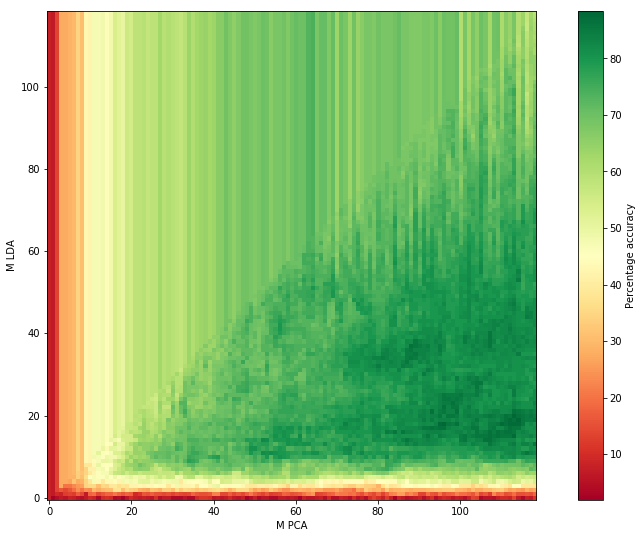

In [14]:
plt.figure(figsize=(15.0,9.0))
plt.imshow(M_lda_pca*100, cmap='RdYlGn', origin='lower')
plt.colorbar(label = 'Percentage accuracy')
plt.xlabel('M PCA')
plt.ylabel('M LDA')
plt.show()

In [15]:
maxboi = pd.DataFrame.max(pd.DataFrame.max(M_lda_pca))
print(maxboi*100, '%')
print(M_lda_pca.idxmax().idxmax()) 
index = np.argmax(np.asarray(M_lda_pca))
print(index)
M_lda_pca_shape = np.asarray(M_lda_pca).shape
M_LDA_max, M_PCA_max = divmod(index, M_lda_pca_shape[0]) #check if this is 118 or 118?? 
print(M_PCA_max, M_LDA_max)

88.46153846153845 %
88
2238
96 18


Text(0, 0.5, 'Correct Class')

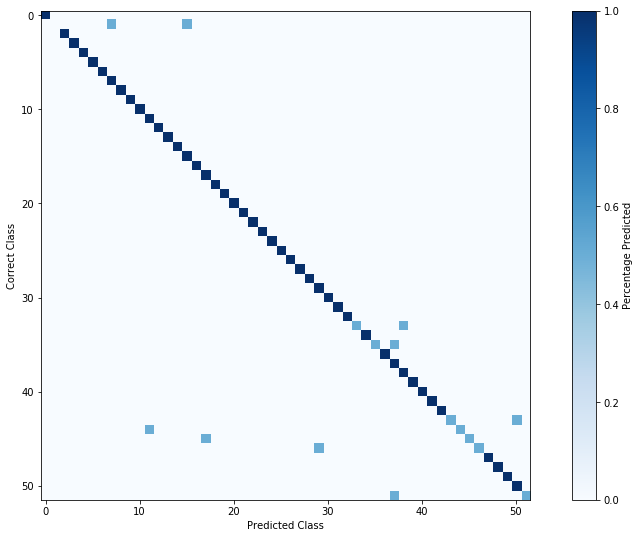

In [16]:
plt.figure(figsize=(15.0,9.0))
plt.imshow(confusion_matrix(l_test[0], l_pred)/2,cmap='Blues')
plt.colorbar(label='Percentage Predicted')
plt.xlabel('Predicted Class')
plt.ylabel('Correct Class')